repeat

# Set up

In [147]:
## import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
import random, sys, copy, os, json

In [148]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Ensure deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [149]:
score_columns = ["domain %d score" %i for i in range(1, 15)]
encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
target_columns = ["domain %d target" %i for i in range(1, 15)]
repeat_columns = ["repeat"]
time_columns = ["start_time"]

## read data and define test set

In [150]:
data = pd.read_csv("data/next_step_data.csv")

In [151]:
data.shape

(5835365, 45)

In [152]:
data.nunique()

patient_id               4399
domain 1 encoding           2
domain 2 encoding           2
domain 3 encoding           2
domain 4 encoding           2
domain 5 encoding           2
domain 6 encoding           2
domain 7 encoding           2
domain 8 encoding           2
domain 9 encoding           2
domain 10 encoding          2
domain 11 encoding          2
domain 12 encoding          2
domain 13 encoding          2
domain 14 encoding          2
domain 1 score            385
domain 2 score            198
domain 3 score            456
domain 4 score            302
domain 5 score            459
domain 6 score            409
domain 7 score            371
domain 8 score            370
domain 9 score            317
domain 10 score           596
domain 11 score            51
domain 12 score           612
domain 13 score           708
domain 14 score           433
domain 1 target           385
domain 2 target           198
domain 3 target           456
domain 4 target           302
domain 5 t

In [153]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
# n_samples = 100000
# test_data = test_data[:n_samples].copy() ## only take n_samples

In [154]:
test_data

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
5198989,321864.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000,1.0,1.602174e+09
4478682,268337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222,0.0,0.307,0.500,0.64,0.364,0.644,0.200,1.0,1.672064e+09
108777,16506.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN,1.0,1.678826e+09
5428722,333131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.000,0.492,0.76,0.333,0.881,0.200,1.0,1.682856e+09
3125710,191189.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474,1.0,1.546050e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187251,321071.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,1.0,0.787,1.000,1.00,1.000,1.000,0.887,1.0,1.579381e+09
5025510,312055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.048,NaN,NaN,NaN,0.089,1.0,1.563748e+09
870943,81648.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,1.0,1.528247e+09
5732377,354946.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.754,NaN,0.273,0.286,0.987,1.0,1.581274e+09


In [155]:
# specific sessions to track
# session_id = [3511929, 217809, 4313511, 3694380, 5151980, 3640067, 5313162, 1813788, 4876271, 5025916, 4621927, 2592816, 3673390]
# test_data = test_data.loc[session_id]
test_data

,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
5198989,321864.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000,1.0,1.602174e+09
4478682,268337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222,0.0,0.307,0.500,0.64,0.364,0.644,0.200,1.0,1.672064e+09
108777,16506.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN,1.0,1.678826e+09
5428722,333131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,1.000,0.492,0.76,0.333,0.881,0.200,1.0,1.682856e+09
3125710,191189.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474,1.0,1.546050e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187251,321071.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,1.0,0.787,1.000,1.00,1.000,1.000,0.887,1.0,1.579381e+09
5025510,312055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.048,NaN,NaN,NaN,0.089,1.0,1.563748e+09
870943,81648.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,1.0,1.528247e+09
5732377,354946.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.754,NaN,0.273,0.286,0.987,1.0,1.581274e+09


In [156]:
test_data[encoding_columns]

,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,domain 10 encoding,domain 11 encoding,domain 12 encoding,domain 13 encoding,domain 14 encoding
5198989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4478682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
108777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5428722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3125710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187251,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5025510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
870943,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5732377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [157]:
test_data[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
5198989,0.526,0.02,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
4478682,0.526,0.11,1.000,0.400,0.168,0.013,0.222,0.0,0.307,0.485,0.64,0.364,0.644,0.200
108777,1.000,1.00,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
5428722,0.516,0.73,1.000,1.000,0.658,NaN,NaN,NaN,1.000,0.500,0.80,0.333,0.881,0.200
3125710,0.428,0.42,0.880,0.243,0.170,0.263,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187251,1.000,0.65,1.000,0.988,0.968,1.000,NaN,1.0,0.787,1.000,1.00,1.000,1.000,0.887
5025510,NaN,NaN,NaN,0.071,NaN,0.513,NaN,NaN,NaN,0.048,NaN,NaN,NaN,0.089
870943,NaN,NaN,0.067,0.000,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN
5732377,0.684,0.15,0.682,0.625,0.252,0.907,NaN,NaN,NaN,0.754,NaN,0.273,0.319,0.987


In [158]:
test_data[target_columns]

,domain 1 target,domain 2 target,domain 3 target,domain 4 target,domain 5 target,domain 6 target,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target
5198989,0.526,0.02,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
4478682,0.526,0.11,1.000,0.400,0.168,0.013,0.222,0.0,0.307,0.500,0.64,0.364,0.644,0.200
108777,1.000,1.00,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
5428722,0.516,0.73,1.000,1.000,0.658,NaN,NaN,NaN,1.000,0.492,0.76,0.333,0.881,0.200
3125710,0.428,0.42,0.880,0.243,0.170,0.263,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187251,1.000,0.65,1.000,0.988,0.916,1.000,NaN,1.0,0.787,1.000,1.00,1.000,1.000,0.887
5025510,NaN,NaN,NaN,0.071,NaN,0.513,NaN,NaN,NaN,0.048,NaN,NaN,NaN,0.089
870943,NaN,NaN,0.067,0.000,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN
5732377,0.684,0.15,0.682,0.625,0.252,0.907,NaN,NaN,NaN,0.754,NaN,0.273,0.286,0.987


## model set up

In [159]:
# create missing indicator when given the score data
def create_missing_indicator(data):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            # if p == 0:
            if np.isnan(p):
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    assert not np.isnan(temp).any(), "nans exists!!!"
    return copy.deepcopy(temp)

In [160]:
# given a processed dataframe, return data and target numpy arrays
def create_model_data(data : pd.DataFrame):
    target = data[target_columns].copy().to_numpy() * data[encoding_columns].copy().to_numpy()
    print("===== from create_model_data ======")
    data_scores = create_missing_indicator(data[score_columns].copy().to_numpy())
    print("data_scores: ", data_scores)
    print("target: ", target)
    return data_scores, target

In [161]:
# add encoding to scores and return a tensor that can be put directly into the model
def add_encoding(scores : np.ndarray, encoding : np.ndarray):
    return torch.from_numpy(np.hstack((encoding, scores))).float()

In [162]:
## input : 14 domain encodings + 14 domains (28 total features with missing indicator)
## output: 28 score (prediction for the scores after next domain)
## copied from next_step.py, which was used to train the model
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, n_domains)
        )

    def forward(self, x):
        return self.model(x)

# used for batch training
class customDataset(Dataset):
    def __init__(self, data, target):
        super().__init__()
        self.data = data
        self.target = target

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index, :], self.target[index, :]

In [163]:
# initialize the model
model = NN()
model = torch.load("output/experiment4/model.pt", map_location=torch.device('cpu'))

# filter out the non-repeats first for ground truth as the base set

In [164]:
# find whether it is a repeat domain or not
def assign_repeat(df):
    print("================= assign_repeat =============")
    # default to false
    df[repeat_columns] = True
    for idx, row in df.iterrows():
        assignment = True
        # print("the row ", row)
        for encoding_col, score_col in zip(encoding_columns, score_columns):
            # print("columns:" , encoding_col, score_col)
            # Find rows where encoding column is 1
            encoding_is_1 = row[encoding_col] == 1
            
            # Check if the corresponding score column is NaN for those rows
            is_nan = pd.isna(row[score_col])
            # print("encoding is 1 and is nan: ", encoding_is_1, is_nan)
            # Combine the conditions: where encoding column is 1 and score column is NaN
            condition = encoding_is_1 & is_nan
            # print("condition: ", condition)
            if condition:
                assignment = False
                break
            
        # Set the 'repeat' column to True where the condition is met, False otherwise
        # print("assignment: ", assignment)
        df.loc[idx, 'repeat'] = assignment
    # print("after assignment: ", df)
    return df

In [165]:
test_data_assigned  = assign_repeat(test_data)

================= assign_repeat =============


In [166]:
test_data_nonrepeat = test_data_assigned[test_data_assigned.repeat == True].copy()

In [167]:
# make test data copies
ground_truth_test_data = test_data_nonrepeat.copy()
random_test_data = test_data_nonrepeat.copy()
best_test_data = test_data_nonrepeat.copy()

### at this pont, all test data are the same

In [168]:
ground_truth_test_data.shape

(1450104, 45)

# create encoding and find prediction

In [169]:
# return prediction given model and input data
def predict(model, x, y):
    loss_function = torch.nn.MSELoss()
    with torch.no_grad():
        predictions = model(x)
        loss = loss_function(predictions, y.reshape(predictions.shape))    
        return predictions.clone().numpy()

In [170]:
# takes in the score columns of the dataframe, return an encoding that chooses randomly from where the nans are so they are non repeats
def create_random_encoding(df):
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    # Create an output array of zeros
    output = np.zeros(df.shape, dtype=int)

    # Iterate over each row
    for i, row in enumerate(~df.isna().values):
        nan_indices = np.where(row)[0]  # Find indices where NaN is present
        if len(nan_indices) > 0:
            chosen_index = np.random.choice(nan_indices)  # Pick one at random
            output[i, chosen_index] = 1  # Set the chosen position to 1
    
    return output

In [171]:
# take in a dataframe, find predictions and return the predictions
def find_random_predictions(data):
    x, y = create_model_data(data) # create scores with missing indicators and target
    e = data[encoding_columns].to_numpy()
    x_random = add_encoding(x, e)
    predictions = predict(model, x_random, torch.from_numpy(y).float())
    return predictions

### random encoding creation and predict performance

In [172]:
# create random encoding
random_encoding = create_random_encoding(random_test_data[score_columns])
random_test_data[encoding_columns] = random_encoding

In [173]:
# find random prediction
random_prediction = find_random_predictions(random_test_data)
random_test_data[target_columns] = random_prediction # change the target columns to the random_prediction values
random_test_data

===== from create_model_data ======
data_scores:  [[0.526 0.474 0.02  ... 0.919 1.    0.   ]
 [0.526 0.474 0.11  ... 0.356 0.2   0.8  ]
 [1.    0.    1.    ... 0.    0.    0.   ]
 ...
 [1.    1.    1.    ... 1.    1.    1.   ]
 [0.684 0.316 0.15  ... 0.681 0.987 0.013]
 [0.286 0.714 0.35  ... 0.606 1.    0.   ]]
target:  [[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    1.      nan]
 ...
 [  nan   nan 0.    ...   nan 0.      nan]
 [0.684 0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]


,patient_id,domain 1 encoding,domain 2 encoding,domain 3 encoding,domain 4 encoding,domain 5 encoding,domain 6 encoding,domain 7 encoding,domain 8 encoding,domain 9 encoding,...,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target,repeat,start_time
5198989,321864.0,0,0,0,0,0,0,1,0,0,...,0.049341,-0.001655,0.012767,-0.009093,-0.005953,0.001832,-0.005693,0.005315,True,1.602174e+09
4478682,268337.0,0,0,0,1,0,0,0,0,0,...,0.005332,-0.011528,0.010119,0.009151,-0.000932,0.003774,-0.004749,-0.011314,True,1.672064e+09
108777,16506.0,0,0,0,0,0,0,0,0,0,...,0.004950,-0.010512,0.012475,0.000183,0.007124,-0.005505,0.971063,0.000146,True,1.678826e+09
5428722,333131.0,0,0,0,0,0,0,0,0,0,...,-0.001949,0.000684,0.035430,0.318130,0.811250,-0.010858,-0.007484,-0.006121,True,1.682856e+09
3125710,191189.0,0,0,0,0,0,0,0,0,0,...,-0.002195,0.000391,0.005997,-0.002368,0.002626,0.006490,-0.009293,0.474411,True,1.546050e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187251,321071.0,0,0,0,0,0,0,0,0,0,...,0.003491,0.000784,-0.004378,-0.001190,-0.003852,0.941920,0.006510,-0.013311,True,1.579381e+09
5025510,312055.0,0,0,0,0,0,0,0,0,0,...,-0.004016,0.000144,-0.004735,0.092709,0.010122,-0.010655,0.002808,-0.004943,True,1.563748e+09
870943,81648.0,0,0,0,0,0,1,0,0,0,...,0.001529,0.001141,-0.000318,-0.012875,-0.005259,0.000661,-0.028681,0.007872,True,1.528247e+09
5732377,354946.0,1,0,0,0,0,0,0,0,0,...,0.001444,-0.004038,-0.002213,0.003596,-0.014730,0.002714,0.001536,0.011470,True,1.581274e+09


### best encoding creation and predict perfomrance

In [174]:
# given the number of rows and cols and index, return a numpy array of according size with all 0s except for specified column
def create_single_encoding(rows, cols, column_index):
    if column_index < 0 or column_index >= cols:
        raise ValueError("Column index is out of bounds.")

    # Create a zero matrix
    matrix = np.zeros((rows, cols), dtype=int)

    # Set all values in the specified column to 1
    matrix[:, column_index] = 1

    return matrix

In [175]:
def max_prediction_from_difference(difference_matrix, prediction_matrix, current_matrix):
    nan_mask = ~np.isnan(current_matrix)  # Boolean mask where True indicates NaN

    # Initialize arrays to store results
    max_indices = np.full(difference_matrix.shape[0], np.nan)  # Store max indices
    max_values = np.full(difference_matrix.shape[0], np.nan)  # Store corresponding prediction values

    # Iterate through each row
    for i in range(difference_matrix.shape[0]):
        valid_indices = np.where(nan_mask[i])[0]  # Get column indices where current_matrix has NaN
        if valid_indices.size > 0:
            valid_differences = difference_matrix[i, valid_indices]  # Select values where NaN exists in current_matrix
            max_idx = np.argmax(valid_differences)  # Find index of max value (relative to valid_indices)
            max_indices[i] = valid_indices[max_idx]  # Store original column index
            max_values[i] = prediction_matrix[i, valid_indices[max_idx]]  # Get corresponding prediction value

    return max_values, max_indices

In [176]:
def reconstruct_max_matrices(max_values, max_indices, shape):
    max_values_matrix = np.zeros(shape)  # Matrix for max values
    max_indices_matrix = np.zeros(shape, dtype=int)  # Matrix for 1s at max indices

    # Iterate through rows
    for i in range(shape[0]):
        if not np.isnan(max_indices[i]):  # Ensure there's a valid index
            col_idx = int(max_indices[i])
            max_values_matrix[i, col_idx] = max_values[i]
            max_indices_matrix[i, col_idx] = 1  # Mark the index with 1

    return max_values_matrix, max_indices_matrix

In [177]:
def min_prediction_from_difference(difference_matrix, prediction_matrix, current_matrix):
    nan_mask = ~np.isnan(current_matrix)  # Boolean mask where True indicates NaN

    # Initialize arrays to store results
    min_indices = np.full(difference_matrix.shape[0], np.nan)  # Store max indices
    min_values = np.full(difference_matrix.shape[0], np.nan)  # Store corresponding prediction values

    # Iterate through each row
    for i in range(difference_matrix.shape[0]):
        valid_indices = np.where(nan_mask[i])[0]  # Get column indices where current_matrix has NaN
        if valid_indices.size > 0:
            valid_differences = difference_matrix[i, valid_indices]  # Select values where NaN exists in current_matrix
            min_idx = np.argmin(valid_differences)  # Find index of max value (relative to valid_indices)
            min_indices[i] = valid_indices[min_idx]  # Store original column index
            min_values[i] = prediction_matrix[i, valid_indices[min_idx]]  # Get corresponding prediction value

    return min_values, min_indices

In [178]:
def reconstruct_min_matrices(min_values, min_indices, shape):
    min_values_matrix = np.zeros(shape)  # Matrix for max values
    min_indices_matrix = np.zeros(shape, dtype=int)  # Matrix for 1s at max indices

    # Iterate through rows
    for i in range(shape[0]):
        if not np.isnan(min_indices[i]):  # Ensure there's a valid index
            col_idx = int(min_indices[i])
            min_values_matrix[i, col_idx] = min_values[i]
            min_indices_matrix[i, col_idx] = 1  # Mark the index with 1

    return min_values_matrix, min_indices_matrix

In [179]:
# create best encoding
x_tmp, y_tmp = create_model_data(best_test_data) # create scores with missing indicators and target
rows, cols = y_tmp.shape
prediction_list = []
# loop through fourteen domains, get the predictions and store the predictions for that domain only in a list
for domain in range(14):
    print("============= domain %d" % (domain + 1))
    encoding = create_single_encoding(rows, cols, domain)
    print("encoding: ", encoding)
    tmp_single = add_encoding(x_tmp, encoding)
    print("data put in model", tmp_single)
    single_prediction = predict(model, tmp_single, torch.from_numpy(y_tmp).float())
    print("prediction: ", single_prediction)
    prediction_list.append(single_prediction[:, domain])

===== from create_model_data ======
data_scores:  [[0.526 0.474 0.02  ... 0.919 1.    0.   ]
 [0.526 0.474 0.11  ... 0.356 0.2   0.8  ]
 [1.    0.    1.    ... 0.    0.    0.   ]
 ...
 [1.    1.    1.    ... 1.    1.    1.   ]
 [0.684 0.316 0.15  ... 0.681 0.987 0.013]
 [0.286 0.714 0.35  ... 0.606 1.    0.   ]]
target:  [[0.    0.    0.    ... 0.    0.081 0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.      nan]
 ...
 [  nan   nan 0.067 ...   nan 0.      nan]
 [0.    0.    0.    ... 0.    0.286 0.   ]
 [0.    0.    0.    ... 0.393 0.394 0.   ]]
============= domain 1
encoding:  [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
data put in model tensor([[1.0000, 0.0000, 0.0000,  ..., 0.9190, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000,  ..., 0.3560, 0.2000, 0.8000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.0000, 0.0000, 0.0000,  ..

In [180]:
x_tmp

array([[0.526, 0.474, 0.02 , ..., 0.919, 1.   , 0.   ],
       [0.526, 0.474, 0.11 , ..., 0.356, 0.2  , 0.8  ],
       [1.   , 0.   , 1.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [1.   , 1.   , 1.   , ..., 1.   , 1.   , 1.   ],
       [0.684, 0.316, 0.15 , ..., 0.681, 0.987, 0.013],
       [0.286, 0.714, 0.35 , ..., 0.606, 1.   , 0.   ]])

In [181]:
prediction_list

[array([0.42421883, 0.5049609 , 0.9779678 , ..., 0.4619909 , 0.636417  ,
        0.26358008], dtype=float32),
 array([0.05316141, 0.1483829 , 0.98007566, ..., 0.55680895, 0.18732864,
        0.33027723], dtype=float32),
 array([0.1462817 , 0.9476464 , 0.96433383, ..., 0.12739824, 0.64591944,
        0.8065038 ], dtype=float32),
 array([0.3306931 , 0.37153944, 0.90246654, ..., 0.11559254, 0.58528066,
        0.23850876], dtype=float32),
 array([0.11111826, 0.17349893, 0.93166447, ..., 0.29286897, 0.25407788,
        0.12413932], dtype=float32),
 array([0.06135439, 0.06429052, 0.4675113 , ..., 0.08019599, 0.84608656,
        0.6920403 ], dtype=float32),
 array([0.04934064, 0.19785866, 0.913955  , ..., 0.47591034, 0.46422824,
        0.81224877], dtype=float32),
 array([0.48791665, 0.10046811, 0.528789  , ..., 0.5933845 , 0.5661546 ,
        0.09579147], dtype=float32),
 array([0.09235591, 0.28050837, 0.9787704 , ..., 0.49208543, 0.417515  ,
        0.10326985], dtype=float32),
 array([0.

In [182]:
prediction_matrix = np.column_stack(prediction_list)  # Shape: (100000, 14)
difference = prediction_matrix - np.nan_to_num(best_test_data[score_columns].to_numpy())

# find max indices
max_values, max_indices = max_prediction_from_difference(difference, prediction_matrix, best_test_data[score_columns].to_numpy())
# reconstruct matrices
best_predictions, best_encoding = reconstruct_max_matrices(max_values, max_indices, prediction_matrix.shape)

# find min indices
min_values, min_indices = min_prediction_from_difference(difference, prediction_matrix, best_test_data[score_columns].to_numpy())
# reconstruct matrices
worst_predictions, worst_encoding = reconstruct_min_matrices(min_values, min_indices, prediction_matrix.shape)

In [183]:
prediction_matrix

array([[0.42421883, 0.05316141, 0.1462817 , ..., 0.13206464, 0.12930726,
        0.9768177 ],
       [0.5049609 , 0.1483829 , 0.9476464 , ..., 0.36525524, 0.65326107,
        0.203392  ],
       [0.9779678 , 0.98007566, 0.96433383, ..., 0.736803  , 0.9710634 ,
        0.57250416],
       ...,
       [0.4619909 , 0.55680895, 0.12739824, ..., 0.5229602 , 0.08509397,
        0.44618586],
       [0.636417  , 0.18732864, 0.64591944, ..., 0.26221484, 0.31635922,
        0.9825738 ],
       [0.26358008, 0.33027723, 0.8065038 , ..., 0.3790577 , 0.38141593,
        0.971588  ]], dtype=float32)

In [184]:
ground_truth_test_data[target_columns]

,domain 1 target,domain 2 target,domain 3 target,domain 4 target,domain 5 target,domain 6 target,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target
5198989,0.526,0.02,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
4478682,0.526,0.11,1.000,0.400,0.168,0.013,0.222,0.0,0.307,0.500,0.64,0.364,0.644,0.200
108777,1.000,1.00,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
5428722,0.516,0.73,1.000,1.000,0.658,NaN,NaN,NaN,1.000,0.492,0.76,0.333,0.881,0.200
3125710,0.428,0.42,0.880,0.243,0.170,0.263,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187251,1.000,0.65,1.000,0.988,0.916,1.000,NaN,1.0,0.787,1.000,1.00,1.000,1.000,0.887
5025510,NaN,NaN,NaN,0.071,NaN,0.513,NaN,NaN,NaN,0.048,NaN,NaN,NaN,0.089
870943,NaN,NaN,0.067,0.000,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN
5732377,0.684,0.15,0.682,0.625,0.252,0.907,NaN,NaN,NaN,0.754,NaN,0.273,0.286,0.987


In [185]:
best_test_data[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
5198989,0.526,0.02,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
4478682,0.526,0.11,1.000,0.400,0.168,0.013,0.222,0.0,0.307,0.485,0.64,0.364,0.644,0.200
108777,1.000,1.00,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
5428722,0.516,0.73,1.000,1.000,0.658,NaN,NaN,NaN,1.000,0.500,0.80,0.333,0.881,0.200
3125710,0.428,0.42,0.880,0.243,0.170,0.263,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187251,1.000,0.65,1.000,0.988,0.968,1.000,NaN,1.0,0.787,1.000,1.00,1.000,1.000,0.887
5025510,NaN,NaN,NaN,0.071,NaN,0.513,NaN,NaN,NaN,0.048,NaN,NaN,NaN,0.089
870943,NaN,NaN,0.067,0.000,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN
5732377,0.684,0.15,0.682,0.625,0.252,0.907,NaN,NaN,NaN,0.754,NaN,0.273,0.319,0.987


In [186]:
difference

array([[-0.10178117,  0.03316141, -0.0017183 , ...,  0.00506464,
         0.04830726, -0.02318227],
       [-0.02103911,  0.0383829 , -0.05235362, ...,  0.00125524,
         0.00926107,  0.003392  ],
       [-0.0220322 , -0.01992434, -0.03566617, ..., -0.003197  ,
        -0.02893662,  0.57250416],
       ...,
       [ 0.46199089,  0.55680895,  0.06039824, ...,  0.52296019,
         0.08509397,  0.44618586],
       [-0.04758303,  0.03732864, -0.03608056, ..., -0.01078516,
        -0.00264078, -0.00442619],
       [-0.02241992, -0.01972277, -0.03349623, ..., -0.01394229,
        -0.01258407, -0.02841198]])

In [187]:
max_indices

array([ 5.,  7., 11., ...,  3.,  1.,  7.])

In [188]:
best_encoding

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [189]:
best_predictions

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.736803  , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.18732864, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [190]:
best_test_data[encoding_columns] = best_encoding
best_test_data[target_columns] = best_predictions

In [191]:
worst_test_data = best_test_data.copy()
worst_test_data[encoding_columns] = worst_encoding
worst_test_data[target_columns] = worst_predictions

# separate by repeat vs non repeat

In [192]:
# random assignment
print("ground truth")
ground_truth_test_data_final  = assign_repeat(ground_truth_test_data)
print("random")
random_test_data_final  = assign_repeat(random_test_data)
print("best")
best_test_data_final  = assign_repeat(best_test_data)
print("worst")
worst_test_data_final = assign_repeat(worst_test_data)

ground truth
================= assign_repeat =============
random
================= assign_repeat =============
best
================= assign_repeat =============
worst
================= assign_repeat =============


# filter depending on number of known domains

In [193]:
# filter rows based on number of missing values (denoted by nans) the session has
def filter_n_missing(df, n_missing):
    global score_columns
    # only use the score columns when counting 0s
    scores = df[score_columns]
    # Count number of nans in each row
    missing_count = scores.isna().sum(axis=1)
    
    # Filter rows with n_zeros number of zeros
    filtered_rows = df[missing_count == n_missing]
    return filtered_rows

In [194]:
# debug print
def debug_filter_print(df):
    n = df.iloc[0][score_columns].isna().sum()
    total_sessions = df.shape[0]
    print("# of missing = %d, # of total sessions = %d" % (n, total_sessions))
    print(np.isnan(df[score_columns]).sum(axis=1).sum() == n * total_sessions)

In [195]:
ground_truth_test_data_n = dict()
random_test_data_n = dict()
best_test_data_n = dict()
worst_test_data_n = dict()

In [196]:
for n in range(1, 14):
    print("======================= filter n missing: n = %d =========================" % n)
    print("============ ground truth ===============")
    tmp = filter_n_missing(ground_truth_test_data_final, n_missing=n)
    ground_truth_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

    print("============ random ================")
    tmp = filter_n_missing(random_test_data_final, n_missing=n)
    random_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

    print("============= best ==================")
    tmp = filter_n_missing(best_test_data_final, n_missing=n)
    best_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

    print("============= worst ==================")
    tmp = filter_n_missing(worst_test_data_final, n_missing=n)
    worst_test_data_n[n] = tmp.copy()
    debug_filter_print(tmp)

======================= filter n missing: n = 1 =========================
============ ground truth ===============
# of missing = 1, # of total sessions = 316451
True
============ random ================
# of missing = 1, # of total sessions = 316451
True
============= best ==================
# of missing = 1, # of total sessions = 316451
True
============= worst ==================
# of missing = 1, # of total sessions = 316451
True
======================= filter n missing: n = 2 =========================
============ ground truth ===============
# of missing = 2, # of total sessions = 215654
True
============ random ================
# of missing = 2, # of total sessions = 215654
True
============= best ==================
# of missing = 2, # of total sessions = 215654
True
============= worst ==================
# of missing = 2, # of total sessions = 215654
True
======================= filter n missing: n = 3 =========================
============ ground truth ===============
# of mis

In [197]:
ground_truth_test_data_final[score_columns] ## all three should be the same -> current score shouldn't be modified

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
5198989,0.526,0.02,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
4478682,0.526,0.11,1.000,0.400,0.168,0.013,0.222,0.0,0.307,0.485,0.64,0.364,0.644,0.200
108777,1.000,1.00,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
5428722,0.516,0.73,1.000,1.000,0.658,NaN,NaN,NaN,1.000,0.500,0.80,0.333,0.881,0.200
3125710,0.428,0.42,0.880,0.243,0.170,0.263,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187251,1.000,0.65,1.000,0.988,0.968,1.000,NaN,1.0,0.787,1.000,1.00,1.000,1.000,0.887
5025510,NaN,NaN,NaN,0.071,NaN,0.513,NaN,NaN,NaN,0.048,NaN,NaN,NaN,0.089
870943,NaN,NaN,0.067,0.000,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN
5732377,0.684,0.15,0.682,0.625,0.252,0.907,NaN,NaN,NaN,0.754,NaN,0.273,0.319,0.987


In [198]:
random_test_data_final[score_columns]

,domain 1 score,domain 2 score,domain 3 score,domain 4 score,domain 5 score,domain 6 score,domain 7 score,domain 8 score,domain 9 score,domain 10 score,domain 11 score,domain 12 score,domain 13 score,domain 14 score
5198989,0.526,0.02,0.148,0.375,0.129,0.000,0.022,NaN,0.080,0.454,0.80,0.127,0.081,1.000
4478682,0.526,0.11,1.000,0.400,0.168,0.013,0.222,0.0,0.307,0.485,0.64,0.364,0.644,0.200
108777,1.000,1.00,1.000,1.000,1.000,NaN,0.950,NaN,1.000,1.000,1.00,0.740,1.000,NaN
5428722,0.516,0.73,1.000,1.000,0.658,NaN,NaN,NaN,1.000,0.500,0.80,0.333,0.881,0.200
3125710,0.428,0.42,0.880,0.243,0.170,0.263,0.180,NaN,0.260,0.607,1.00,0.457,0.291,0.474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5187251,1.000,0.65,1.000,0.988,0.968,1.000,NaN,1.0,0.787,1.000,1.00,1.000,1.000,0.887
5025510,NaN,NaN,NaN,0.071,NaN,0.513,NaN,NaN,NaN,0.048,NaN,NaN,NaN,0.089
870943,NaN,NaN,0.067,0.000,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN
5732377,0.684,0.15,0.682,0.625,0.252,0.907,NaN,NaN,NaN,0.754,NaN,0.273,0.319,0.987


# score aggregate

In [199]:
def overall_avg_improvement_with_std(df):
    pred_score = df[target_columns].to_numpy()
    cur_score = df[score_columns].to_numpy()
    encoding = df[encoding_columns].to_numpy()

    print("prediction score: ", pred_score)
    print("current score: ", cur_score)
    print("encoding: ", encoding)

    pred_score = np.nan_to_num(pred_score, nan=0) * encoding
    cur_score = np.nan_to_num(cur_score, nan=0) * encoding
    assert pred_score.shape == cur_score.shape and cur_score.shape == encoding.shape

    # Compute improvement
    improvement = encoding * (pred_score - cur_score)

    # Extract nonzero values
    nonzero_improvement = improvement[improvement != 0]

    if len(nonzero_improvement) == 0:
        avg_improvement = 0
        std_dev = 0
        print("No sessions with nonzero improvement")
    else:
        avg_improvement = np.mean(nonzero_improvement)
        std_dev = np.std(nonzero_improvement, ddof=1)  # Using sample standard deviation (ddof=1)

        print("Number of predicted domains:", len(nonzero_improvement))
        print("Average improvement:", avg_improvement)
        print("Standard deviation:", std_dev)

    return avg_improvement, std_dev

In [200]:
nonrepeat_ground_truth_avg = []
nonrepeat_random_avg = []
nonrepeat_best_avg = []
nonrepeat_worst_avg = []

nonrepeat_ground_truth_std = []
nonrepeat_random_std = []
nonrepeat_best_std = []
nonrepeat_worst_std = []

In [201]:
for n in range(1, 14):
    print("========= %d missing" % n)
    print("----ground truth----")
    # ground truth
    temp_nonrepeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == True]
    if len(temp_nonrepeat) != 0:
        nonrepeat_ground_truth_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_ground_truth_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[1])
    else:
        nonrepeat_ground_truth_avg.append(0)
        nonrepeat_ground_truth_std.append(0)

    print("----random----")
    # random
    temp_nonrepeat = random_test_data_n[n][random_test_data_n[n].repeat == True]
    print("***nonrepeat***")
    if len(temp_nonrepeat) != 0:
        nonrepeat_random_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_random_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[1])
    else:
        nonrepeat_random_avg.append(0)
        nonrepeat_random_std.append(0)
    
    print("----best----")
    # best
    temp_nonrepeat = best_test_data_n[n][best_test_data_n[n].repeat == True]
    print("***nonrepeat***")
    if len(temp_nonrepeat) != 0:
        nonrepeat_best_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_best_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[1])
    else:
        nonrepeat_best_avg.append(0)
        nonrepeat_best_std.append(0)

    print("----worst----")
    # worst
    temp_nonrepeat = worst_test_data_n[n][worst_test_data_n[n].repeat == True]
    print("***nonrepeat***")
    if len(temp_nonrepeat) != 0:
        nonrepeat_worst_avg.append(overall_avg_improvement_with_std(temp_nonrepeat)[0])
        nonrepeat_worst_std.append(overall_avg_improvement_with_std(temp_nonrepeat)[1])
    else:
        nonrepeat_worst_avg.append(0)
        nonrepeat_worst_std.append(0)

========= 1 missing
----ground truth----
prediction score:  [[0.526 0.02  0.148 ... 0.127 0.081 1.   ]
 [0.428 0.42  0.88  ... 0.457 0.291 0.474]
 [0.789 0.39  0.852 ... 0.758 0.784   nan]
 ...
 [0.372 0.92  1.    ... 0.707 0.624 0.713]
 [0.831 0.79  0.333 ... 1.    0.243   nan]
 [1.    0.65  1.    ... 1.    1.    0.887]]
current score:  [[0.526 0.02  0.148 ... 0.127 0.081 1.   ]
 [0.428 0.42  0.88  ... 0.457 0.291 0.474]
 [0.789 0.39  0.852 ... 0.758 0.784   nan]
 ...
 [0.372 0.92  1.    ... 0.707 0.624 0.713]
 [0.831 0.79  0.333 ... 1.    0.243   nan]
 [1.    0.65  1.    ... 1.    1.    0.887]]
encoding:  [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of predicted domains: 155562
Average improvement: 0.0017928864375618722
Standard deviation: 0.0732586784094019
prediction score:  [[0.526 0.02  0.148 ... 0.127 0.081 1.   ]
 [0.428 0.42  0.88  ... 0.457 0.291 0.474]
 [0.78

# Prediction accuracy using ground truth data

In [ ]:
def plot_error_by_nan_count_nonzero_only(prediction_matrix, ground_truth_df, metric="mae"):
    """
    Plots error per number of NaNs in score columns with error bars, considering only nonzero values.

    Parameters:
    prediction_matrix (np.ndarray): 2D NumPy array of predicted values.
    ground_truth_df (pd.DataFrame): DataFrame containing ground truth and score columns.
    metric (str): "mae" for Mean Absolute Error, "mse" for Mean Squared Error.
    """
    global score_columns  # List of score column names
    global target_columns  # List of target columns
    global encoding_columns  # List of encoding columns

    # new_df = pd.DataFrame(data=)

    mean_errors_list = []
    ground_truth_std_list = []
    nan_counts = list(range(1, 14))  # Checking sessions with 1 to 13 NaNs
    ground_truth_dict = dict()
    mean_data = []

    for n in nan_counts:
        print("n == ", n)
        filtered_df = filter_n_missing(ground_truth_df, n)  # Filter by NaN count
        
        if filtered_df.empty:  # Skip if no data
            assert(True)
            mean_errors_list.append(np.nan)
            ground_truth_std_list.append(np.nan)
            continue

        # Correctly map DataFrame indices to NumPy indices
        valid_indices = ground_truth_df.index.get_indexer(filtered_df.index)
        valid_indices = valid_indices[valid_indices >= 0]  # Ensure only valid indices are used
        print("valid indices: ", valid_indices)
        # Extract matrices
        ground_truth_matrix = np.nan_to_num(filtered_df[target_columns].to_numpy()[filtered_df[encoding_columns].to_numpy() == 1])
        filtered_prediction_matrix = prediction_matrix[valid_indices][filtered_df[encoding_columns].to_numpy() == 1]

        # Ensure matrices have the same shape
        assert filtered_prediction_matrix.shape == ground_truth_matrix.shape, "Mismatch in matrix shapes"
        print("ground truth: ", ground_truth_matrix)
        print("prediction: ", filtered_prediction_matrix)
        # Compute improvement (errors)
        errors = np.abs(filtered_prediction_matrix - ground_truth_matrix) if metric == "mae" else (filtered_prediction_matrix - ground_truth_matrix) ** 2

        # print("Shape of filtered_df for n = %d: %d" % (n, filtered_df.shape[0]))
        # Extract only nonzero errors
        nonzero_errors = errors
        nonzero_ground_truth = ground_truth_matrix

        ground_truth_dict[str(n)] = nonzero_ground_truth

        # print("number of domainss known total (might be more than number of sessions)", filtered_df[encoding_columns].to_numpy().sum())
        print("zero_error: ", nonzero_errors)
        # print("shape of nonzero_ground_truth: ", nonzero_ground_truth.shape)
        print("mae output with code from next_step.py: ", np.mean(np.abs(filtered_prediction_matrix - ground_truth_matrix)))

        if len(nonzero_errors) == 0:
            mean_errors_list.append(np.nan)
            ground_truth_std_list.append(np.nan)
            mean_data.append(np.nan)
        else:
            mean_errors_list.append(np.mean(nonzero_errors))
            ground_truth_std_list.append(np.std(nonzero_ground_truth, ddof=1))  # Sample standard deviation
            mean_data.append(np.mean(nonzero_ground_truth))

    # Convert to numpy arrays
    mean_errors = np.array(mean_errors_list)
    error_std = np.array(ground_truth_std_list)
    # convert dictionary to dataframe for plotting
    plot_df = pd.concat(map(pd.Series, ground_truth_dict.values()), keys=ground_truth_dict.keys(), axis=1)


    # Plot
    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.boxplot(data=plot_df, ax=axes)
    # axes.plot(plot_df.keys(), mean_errors, label="Prediction MAE", color="cyan")
    axes.plot(plot_df.keys(), mean_data - mean_errors, label="Prediction MAE", color="cyan")
    axes.plot(plot_df.keys(), mean_data + mean_errors, color="cyan")
    axes.plot(plot_df.keys(), mean_data, label="Ground Truth Mean", marker="x", color="red", linewidth=2)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Score")
    plt.title(f"Ground Truth Distribution and Average Prediction of Repeat Sessions")
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Show plot
    plt.show()


    plt.figure()
    plt.plot(nan_counts, error_std, label="ground truth std", marker="x", color="green")
    plt.plot(nan_counts, mean_errors, label="Prediction MAE", marker="o", color="blue")
    # plt.errorbar(nan_counts, mean_errors, yerr=error_std, fmt='-o', capsize=5, color='b', alpha=0.7)
    plt.xticks(nan_counts)
    plt.ylim(0, 0.4)

    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Error")
    plt.title(f"Prediction {metric.upper()} and Ground Truth Std. Comparison for Repeat Sessions")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    plt.show()


In [203]:
x_tmp, y_tmp = create_model_data(ground_truth_test_data_final) # create scores with missing indicators and target
rows, cols = y_tmp.shape
encoding = ground_truth_test_data_final[encoding_columns].to_numpy()
print("encoding: ", encoding)
x_train_tmp = add_encoding(x_tmp, encoding)
print("data put in model", x_train_tmp)
ground_truth_prediction = predict(model, x_train_tmp, torch.from_numpy(y_tmp).float())

===== from create_model_data ======
data_scores:  [[0.526 0.474 0.02  ... 0.919 1.    0.   ]
 [0.526 0.474 0.11  ... 0.356 0.2   0.8  ]
 [1.    0.    1.    ... 0.    0.    0.   ]
 ...
 [1.    1.    1.    ... 1.    1.    1.   ]
 [0.684 0.316 0.15  ... 0.681 0.987 0.013]
 [0.286 0.714 0.35  ... 0.606 1.    0.   ]]
target:  [[0.    0.    0.    ... 0.    0.081 0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.      nan]
 ...
 [  nan   nan 0.067 ...   nan 0.      nan]
 [0.    0.    0.    ... 0.    0.286 0.   ]
 [0.    0.    0.    ... 0.393 0.394 0.   ]]
encoding:  [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]]
data put in model tensor([[0.0000, 0.0000, 0.0000,  ..., 0.9190, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.3560, 0.2000, 0.8000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000

# Visualizations

## prediction accuracy

n ==  1
valid indices:  [      0       4       5 ... 1450097 1450098 1450099]
ground truth:  [0.081 0.291 0.754 ... 0.467 0.988 0.916]
prediction:  [0.12930726 0.29509237 0.762596   ... 0.48550156 0.9397052  0.95791256]
zero_error:  [0.04830726 0.00409237 0.00859601 ... 0.01850156 0.04829481 0.04191256]
mae output with code from next_step.py:  0.03109610678984657
n ==  2
valid indices:  [     20      36      38 ... 1450075 1450076 1450090]
ground truth:  [0.964 0.78  1.    ... 0.443 0.579 0.88 ]
prediction:  [0.9582546  0.75884664 0.926605   ... 0.4481961  0.60628307 0.9625412 ]
zero_error:  [0.00574542 0.02115336 0.07339501 ... 0.00519611 0.02728307 0.08254122]
mae output with code from next_step.py:  0.03271450814971245
n ==  3
valid indices:  [      2       3      12 ... 1450060 1450073 1450086]
ground truth:  [1.    0.492 0.76  ... 0.327 0.72  0.336]
prediction:  [0.9702444  0.49927953 0.8009611  ... 0.30796626 0.7567147  0.2921157 ]
zero_error:  [0.02975559 0.00727953 0.04096108 .

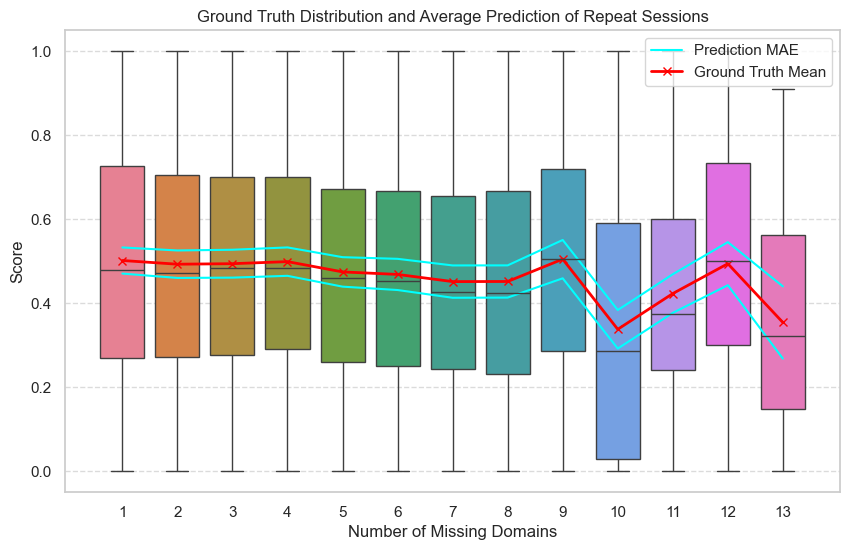

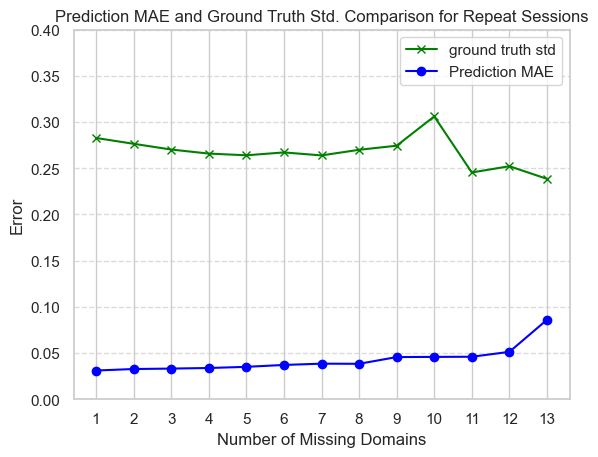

In [204]:
plot_error_by_nan_count_nonzero_only(ground_truth_prediction, ground_truth_test_data_final, metric="mae")  # Use "mse" for Mean Squared Error

## average improvement/score by number of missing domains

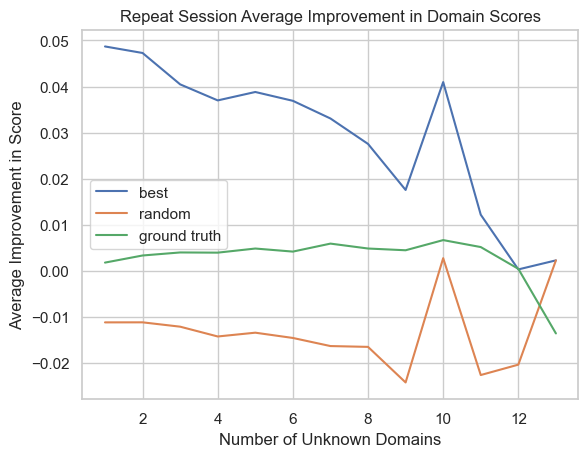

In [205]:
plt.figure()
plt.plot(range(1, 14), nonrepeat_best_avg, label="best")
plt.plot(range(1, 14), nonrepeat_random_avg, label="random")
plt.plot(range(1, 14), nonrepeat_ground_truth_avg, label="ground truth")
plt.xlabel("Number of Unknown Domains")
plt.ylabel("Average Improvement in Score")
plt.title("Repeat Session Average Improvement in Domain Scores")
plt.legend()
plt.show()

## violin plot for score

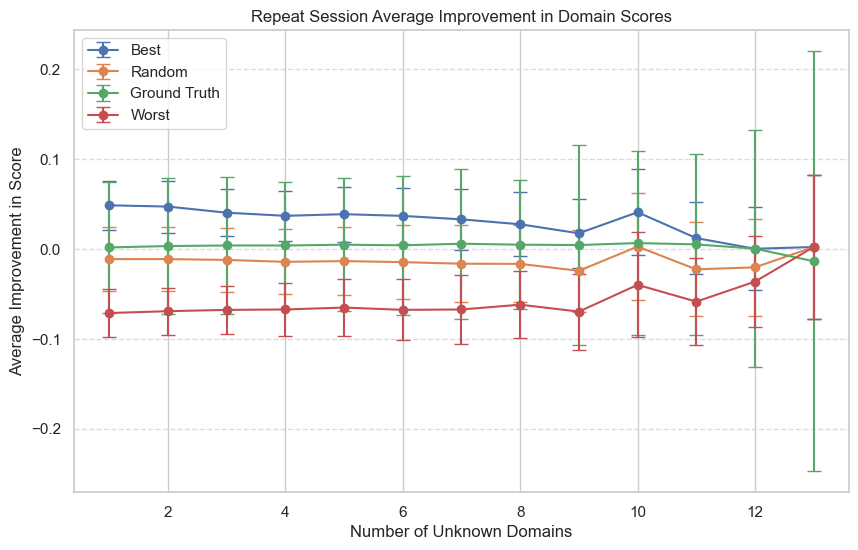

In [ ]:
# Define x-axis values (number of unknown domains)
x_values = range(1, 14)

# Plot with error bars
plt.figure(figsize=(10, 6))

plt.errorbar(x_values, nonrepeat_best_avg, yerr=nonrepeat_best_std, label="Best", fmt='-o', capsize=5)
plt.errorbar(x_values, nonrepeat_random_avg, yerr=nonrepeat_random_std, label="Random", fmt='-o', capsize=5)
plt.errorbar(x_values, nonrepeat_ground_truth_avg, yerr=nonrepeat_ground_truth_std, label="Ground Truth", fmt='-o', capsize=5)
# plt.errorbar(x_values, nonrepeat_worst_avg, yerr=nonrepeat_worst_std, label="Worst", fmt='-o', capsize=5)

# Labels and Title
plt.xlabel("Number of Unknown Domains")
plt.ylabel("Average Improvement in Score")
plt.title("Repeat Session Average Improvement in Domain Scores")

# Legend and Grid
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [207]:
def plot_violin_difference(ground_truth_data_df, random_data_df, best_data_df):
    ## set up variables
    ground_truth_dict = dict()
    random_dict = dict()
    best_dict = dict()

    ## go through data to obtain what's needed for plots
    for n in range(1, 14):
        print("========= %d missing" % n)
        ## set the variables for what we are working with
        print("----ground truth----")
        ground_truth_temp = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == True]
        ground_truth_target_matrix = np.nan_to_num(ground_truth_temp[target_columns].to_numpy()[ground_truth_temp[encoding_columns].to_numpy() == 1])
        ground_truth_current_matrix = np.nan_to_num(ground_truth_temp[score_columns].to_numpy()[ground_truth_temp[encoding_columns].to_numpy() == 1])
        print("current ground truth: ", ground_truth_current_matrix)
        print("target ground truth: ", ground_truth_target_matrix)
        ground_truth_improvement = ground_truth_target_matrix - ground_truth_current_matrix
        ground_truth_dict[str(n)] = ground_truth_improvement
        
        print("----random----")
        random_temp = random_test_data_n[n][random_test_data_n[n].repeat == True]
        random_target_matrix = np.nan_to_num(random_temp[target_columns].to_numpy()[random_temp[encoding_columns].to_numpy() == 1])
        random_current_matrix = np.nan_to_num(random_temp[score_columns].to_numpy()[random_temp[encoding_columns].to_numpy() == 1])
        print("current random: ", random_current_matrix)
        print("target random: ", random_target_matrix)
        random_improvement = random_target_matrix - random_current_matrix
        random_dict[str(n)] = random_improvement

        print("----best----")
        best_temp = best_test_data_n[n][best_test_data_n[n].repeat == True]
        best_target_matrix = np.nan_to_num(best_temp[target_columns].to_numpy()[best_temp[encoding_columns].to_numpy() == 1])
        best_current_matrix = np.nan_to_num(best_temp[score_columns].to_numpy()[best_temp[encoding_columns].to_numpy() == 1])
        print("current best: ", best_current_matrix)
        print("target best: ", best_target_matrix)
        best_improvement = best_target_matrix - best_current_matrix
        best_dict[str(n)] = best_improvement

        ## assert and print statements for debugging
        # assert ground_truth_temp.shape == random_temp.shape and best_temp.shape == ground_truth_temp.shape, "shapes between don't match"

    ## create plot_df
    plot_df_ground_truth = pd.concat(map(pd.Series, ground_truth_dict.values()), keys=ground_truth_dict.keys(), axis=1)
    plot_df_random = pd.concat(map(pd.Series, random_dict.values()), keys=random_dict.keys(), axis=1)
    plot_df_best = pd.concat(map(pd.Series, best_dict.values()), keys=best_dict.keys(), axis=1)


    # Plot
    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.boxplot(data=plot_df_ground_truth, ax=axes)
    # sns.violinplot(data=plot_df_random, ax=axes)
    # sns.violinplot(data=plot_df_best, ax=axes)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Average Improvement")
    plt.title(f"Ground Truth Average Improvement in Score Distribution by Number of Missing domains")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(-0.3, 0.3)
    plt.legend()

    # Show plot
    plt.show()

    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.boxplot(data=plot_df_random, ax=axes)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Average Improvement")
    plt.title(f"Random Average Improvement in Score Distribution by Number of Missing domains")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Show plot
    plt.show()

    fig, axes = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.boxplot(data=plot_df_best, ax=axes)
    plt.xlabel("Number of Missing Domains")
    plt.ylabel("Average Improvement")
    plt.title(f"Best Average Improvement in Score Distribution by Number of Missing domains")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()

    # Show plot
    plt.show()

========= 1 missing
----ground truth----
current ground truth:  [0.081 0.291 0.785 ... 0.467 0.988 0.968]
target ground truth:  [0.081 0.291 0.754 ... 0.467 0.988 0.916]
----random----
current random:  [0.022 0.474 0.677 ... 1.    1.    1.   ]
target random:  [0.04934064 0.47441083 0.7064481  ... 0.9747595  0.89217746 0.9419195 ]
----best----
current best:  [0.    0.18  0.52  ... 0.44  0.333 0.65 ]
target best:  [0.06135439 0.19047782 0.65601796 ... 0.47414848 0.38187855 0.69684005]
========= 2 missing
----ground truth----
current ground truth:  [0.964 0.78  0.935 ... 0.443 0.579 1.   ]
target ground truth:  [0.964 0.78  1.    ... 0.443 0.579 0.88 ]
----random----
current random:  [0.85  0.464 0.935 ... 0.515 0.013 1.   ]
target random:  [0.846409   0.45325708 0.926605   ... 0.5290094  0.0908338  0.9524001 ]
----best----
current best:  [0.286 0.37  0.916 ... 0.25  0.013 0.579]
target best:  [0.29668626 0.37567627 0.9242751  ... 0.31124309 0.0908338  0.59222758]
========= 3 missing
----

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_72361/1372381209.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


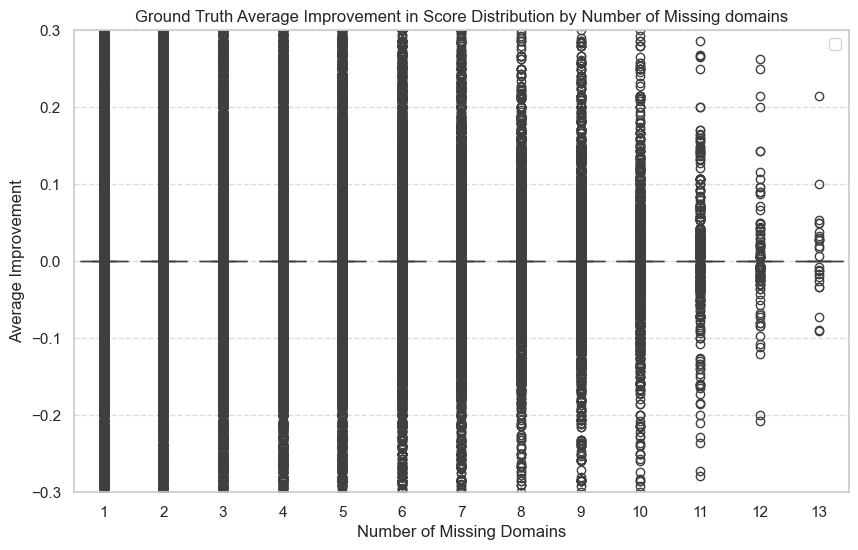

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_72361/1372381209.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


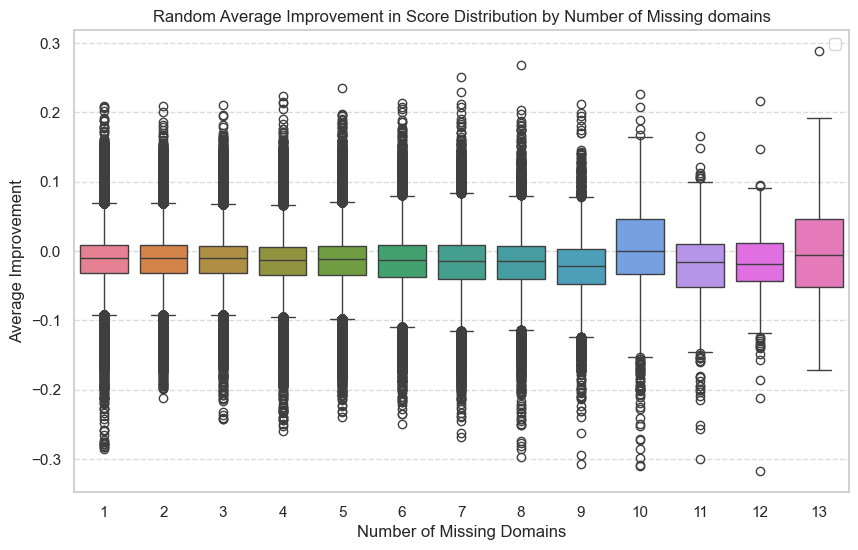

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_72361/1372381209.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


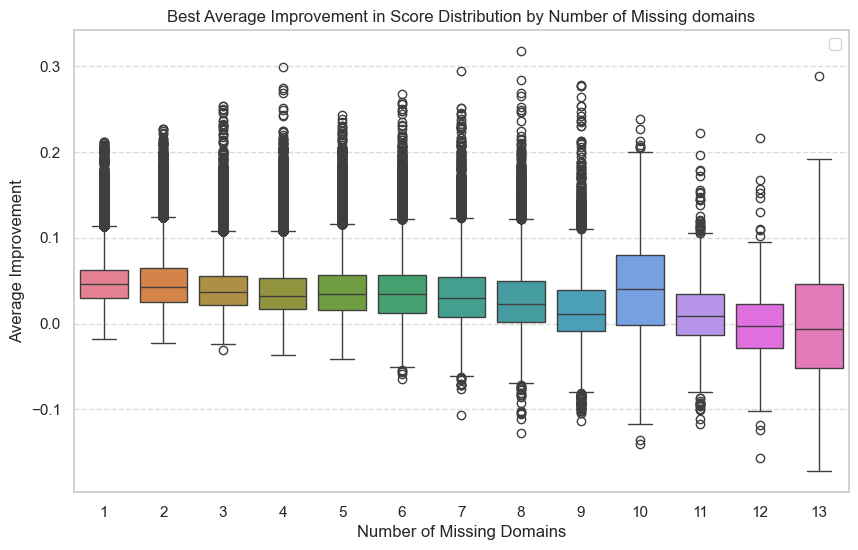

In [208]:
plot_violin_difference(ground_truth_test_data_final, random_test_data_final, best_test_data_final)

# Misc

In [209]:
ids = []

In [210]:
for n in range(1, 14):
    temp_repeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == True]
    temp_nonrepeat = ground_truth_test_data_n[n][ground_truth_test_data_n[n].repeat == False]
    if len(temp_repeat) != 0:
        ids.append(temp_repeat.index[0])
    if len(temp_nonrepeat) != 0:
        ids.append(temp_nonrepeat.index[0])

In [211]:
ids

[5198989,
 4134494,
 108777,
 4184746,
 2051828,
 5447081,
 4856734,
 4203617,
 3485634,
 2213497,
 274747,
 3888559,
 4325322]

Bad pipe message: %s [b'\xeb\x98\x0fJ\xc8r\x08\x02b\xe2\xef\x1d\xc6o\x8b\xef6\x04\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03']
Bad pipe message: %s [b'\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08']
Bad pipe message: %s [b'\xcfK\xc8\n\xd9\xd3\xc6\x15s\x97\xb2\x1c/a>\xfcg\xc1\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x